In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sb3_contrib import RecurrentPPO  # Change 1: Import from sb3_contrib
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, CallbackList, EvalCallback
from asv_glider_bearing_dist_env import AsvGliderBearingEnv

# --- 1. Define the Rollout Callback (Updated for LSTM) ---
class TrajectoryPlotCallback(BaseCallback):
    def __init__(self, eval_env, render_freq=10000, log_dir="./rollouts/"):
        super().__init__()
        self.eval_env = eval_env
        self.render_freq = render_freq
        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.render_freq == 0:
            obs, _ = self.eval_env.reset(seed=123) 
            asv_history, glider_history = [], []
            done = False
            
            # Recurrent models MUST track the LSTM hidden states
            lstm_states = None
            # episode_start mask tells the LSTM when to reset its memory
            episode_starts = np.ones((1,), dtype=bool)

            while not done:
                # We pass the state and start mask into the prediction
                action, lstm_states = self.model.predict(
                    obs, 
                    state=lstm_states, 
                    episode_start=episode_starts, 
                    deterministic=True
                )
                obs, reward, terminated, truncated, _ = self.eval_env.step(action)
                
                asv_history.append(self.eval_env.unwrapped.asv_pos.copy())
                glider_history.append(self.eval_env.unwrapped.glider_pos.copy())
                
                done = terminated or truncated
                # Update mask: if done, the next step is a new start
                episode_starts = np.array([done])

            asv_history, glider_history = np.array(asv_history), np.array(glider_history)
            
            plt.figure(figsize=(6, 6))
            plt.plot(glider_history[:, 0], glider_history[:, 1], 'g--', label="Glider Path", alpha=0.6)
            plt.plot(asv_history[:, 0], asv_history[:, 1], 'b-', label="ASV Path (RecPPO)", linewidth=2)
            plt.title(f"Recurrent PPO Rollout at Step {self.n_calls}")
            plt.xlabel("X Position (m)")
            plt.ylabel("Y Position (m)")
            plt.legend()
            plt.grid(True)
            
            save_path = os.path.join(self.log_dir, f"rollout_{self.n_calls}.png")
            plt.savefig(save_path)
            plt.close()
            print(f">>> Saved Recurrent PPO rollout to {save_path}")
        return True

# --- 2. Setup Directories and Environments ---
algo_name = "rec_ppo" 
base_path = f"./experiments/{algo_name}/"
os.makedirs(base_path, exist_ok=True)

env = AsvGliderBearingEnv()
env = Monitor(env, os.path.join(base_path, "training_logs"))

eval_env = AsvGliderBearingEnv()
eval_env = Monitor(eval_env, os.path.join(base_path, "eval_logs"))

# --- 3. Initialize Recurrent PPO Model ---
model = RecurrentPPO(
    "MlpLstmPolicy",      # Change 2: Use the LSTM Policy
    env,
    verbose=1,
    learning_rate=2e-4, 
    n_steps=2048,         
    batch_size=64,        
    n_epochs=10,          
    gamma=0.99,
    device="cuda",
)

# --- 4. Callbacks ---
eval_callback = EvalCallback(
    eval_env, 
    best_model_save_path=os.path.join(base_path, "best_model"),
    log_path=os.path.join(base_path, "eval_results"), 
    eval_freq=5000,
    deterministic=True,
    render=False
)

plot_callback = TrajectoryPlotCallback(
    eval_env, 
    render_freq=10000, 
    log_dir=os.path.join(base_path, "rollouts")
)

callbacks = CallbackList([eval_callback, plot_callback])

# --- 5. Train ---
try:
    print(f"Starting training for {algo_name}...")
    model.learn(
        total_timesteps=100_000, 
        callback=callbacks,
        progress_bar=True
    )
except KeyboardInterrupt:
    print("\nTraining interrupted.")
finally:
    env.close()
    eval_env.close()
    model.save(os.path.join(base_path, f"{algo_name}_final_model"))
    print("Environment closed and Recurrent PPO model saved.")

Output()

Using cuda device
Wrapping the env in a DummyVecEnv.
Starting training for rec_ppo...


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -545     |
| time/              |          |
|    fps             | 926      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -471        |
| time/                   |             |
|    fps                  | 578         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016806394 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | 0.000639    |
|    learning_rate        | 0.0002      |
|    loss                 | 31.8        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0194     |
|    std                  | 0.998       |
|    value_loss           | 237         |
-----------------------------------------


Eval num_timesteps=5000, episode_reward=-1154.27 +/- 857.69

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | -1.15e+03  |
| time/                   |            |
|    total_timesteps      | 5000       |
| train/                  |            |
|    approx_kl            | 0.02061049 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.84      |
|    explained_variance   | 0.0011     |
|    learning_rate        | 0.0002     |
|    loss                 | 91.2       |
|    n_updates            | 20         |
|    policy_gradient_loss | -0.0386    |
|    std                  | 1          |
|    value_loss           | 172        |
----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -275     |
| time/              |          |
|    fps             | 400      |
|    iterations      | 3        |
|    time_elapsed    | 15       |
|    total_timesteps | 6144     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -564        |
| time/                   |             |
|    fps                  | 404         |
|    iterations           | 4           |
|    time_elapsed         | 20          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012368212 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.000402   |
|    learning_rate        | 0.0002      |
|    loss                 | 124         |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0204     |
|    std                  | 1           |
|    value_loss           | 236         |
-----------------------------------------


Eval num_timesteps=10000, episode_reward=-1786.83 +/- 787.19

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | -1.79e+03    |
| time/                   |              |
|    total_timesteps      | 10000        |
| train/                  |              |
|    approx_kl            | 0.0133364685 |
|    clip_fraction        | 0.167        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.000234     |
|    learning_rate        | 0.0002       |
|    loss                 | 279          |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.0199      |
|    std                  | 1            |
|    value_loss           | 643          |
------------------------------------------


>>> Saved Recurrent PPO rollout to ./experiments/rec_ppo/rollouts/rollout_10000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -622     |
| time/              |          |
|    fps             | 349      |
|    iterations      | 5        |
|    time_elapsed    | 29       |
|    total_timesteps | 10240    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -729        |
| time/                   |             |
|    fps                  | 358         |
|    iterations           | 6           |
|    time_elapsed         | 34          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.003257696 |
|    clip_fraction        | 0.00586     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.000296   |
|    learning_rate        | 0.0002      |
|    loss                 | 99.2        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00675    |
|    std                  | 1           |
|    value_loss           | 459         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -540        |
| time/                   |             |
|    fps                  | 366         |
|    iterations           | 7           |
|    time_elapsed         | 39          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.010628617 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | 0.000919    |
|    learning_rate        | 0.0002      |
|    loss                 | 363         |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0203     |
|    std                  | 1           |
|    value_loss           | 447         |
-----------------------------------------


Eval num_timesteps=15000, episode_reward=-841.40 +/- 360.25

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -841        |
| time/                   |             |
|    total_timesteps      | 15000       |
| train/                  |             |
|    approx_kl            | 0.008740565 |
|    clip_fraction        | 0.0947      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.000489   |
|    learning_rate        | 0.0002      |
|    loss                 | 12.8        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0077     |
|    std                  | 1.01        |
|    value_loss           | 368         |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -598     |
| time/              |          |
|    fps             | 345      |
|    iterations      | 8        |
|    time_elapsed    | 47       |
|    total_timesteps | 16384    |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -501         |
| time/                   |              |
|    fps                  | 351          |
|    iterations           | 9            |
|    time_elapsed         | 52           |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0074277474 |
|    clip_fraction        | 0.15         |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.0023       |
|    learning_rate        | 0.0002       |
|    loss                 | 61.2         |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.0153      |
|    std                  | 0.994        |
|    value_loss           | 250          |
------------------------------------------


Eval num_timesteps=20000, episode_reward=210.85 +/- 398.27

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 211         |
| time/                   |             |
|    total_timesteps      | 20000       |
| train/                  |             |
|    approx_kl            | 0.022992015 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | -0.00237    |
|    learning_rate        | 0.0002      |
|    loss                 | 30.5        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0364     |
|    std                  | 0.989       |
|    value_loss           | 140         |
-----------------------------------------


New best mean reward!

>>> Saved Recurrent PPO rollout to ./experiments/rec_ppo/rollouts/rollout_20000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -464     |
| time/              |          |
|    fps             | 332      |
|    iterations      | 10       |
|    time_elapsed    | 61       |
|    total_timesteps | 20480    |
---------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -498       |
| time/                   |            |
|    fps                  | 338        |
|    iterations           | 11         |
|    time_elapsed         | 66         |
|    total_timesteps      | 22528      |
| train/                  |            |
|    approx_kl            | 0.01715433 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.81      |
|    explained_variance   | -0.0977    |
|    learning_rate        | 0.0002     |
|    loss                 | 23.8       |
|    n_updates            | 100        |
|    policy_gradient_loss | -0.0297    |
|    std                  | 0.983      |
|    value_loss           | 229        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -510       |
| time/                   |            |
|    fps                  | 344        |
|    iterations           | 12         |
|    time_elapsed         | 71         |
|    total_timesteps      | 24576      |
| train/                  |            |
|    approx_kl            | 0.01626221 |
|    clip_fraction        | 0.196      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.8       |
|    explained_variance   | -0.0325    |
|    learning_rate        | 0.0002     |
|    loss                 | 386        |
|    n_updates            | 110        |
|    policy_gradient_loss | -0.0266    |
|    std                  | 0.982      |
|    value_loss           | 747        |
----------------------------------------


Eval num_timesteps=25000, episode_reward=-929.76 +/- 1235.94

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | -930         |
| time/                   |              |
|    total_timesteps      | 25000        |
| train/                  |              |
|    approx_kl            | 0.0101747895 |
|    clip_fraction        | 0.0755       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.8         |
|    explained_variance   | 0.000789     |
|    learning_rate        | 0.0002       |
|    loss                 | 859          |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.0252      |
|    std                  | 0.98         |
|    value_loss           | 956          |
------------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -542     |
| time/              |          |
|    fps             | 333      |
|    iterations      | 13       |
|    time_elapsed    | 79       |
|    total_timesteps | 26624    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -422        |
| time/                   |             |
|    fps                  | 338         |
|    iterations           | 14          |
|    time_elapsed         | 84          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.016316343 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.79       |
|    explained_variance   | 0.00277     |
|    learning_rate        | 0.0002      |
|    loss                 | 193         |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.015      |
|    std                  | 0.967       |
|    value_loss           | 429         |
-----------------------------------------


Eval num_timesteps=30000, episode_reward=-343.86 +/- 916.04

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -344        |
| time/                   |             |
|    total_timesteps      | 30000       |
| train/                  |             |
|    approx_kl            | 0.022653315 |
|    clip_fraction        | 0.282       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | 0.0422      |
|    learning_rate        | 0.0002      |
|    loss                 | 25          |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0184     |
|    std                  | 0.963       |
|    value_loss           | 333         |
-----------------------------------------


>>> Saved Recurrent PPO rollout to ./experiments/rec_ppo/rollouts/rollout_30000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -376     |
| time/              |          |
|    fps             | 326      |
|    iterations      | 15       |
|    time_elapsed    | 93       |
|    total_timesteps | 30720    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -435        |
| time/                   |             |
|    fps                  | 331         |
|    iterations           | 16          |
|    time_elapsed         | 98          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.009484414 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.76       |
|    explained_variance   | 0.00166     |
|    learning_rate        | 0.0002      |
|    loss                 | 23.5        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00667    |
|    std                  | 0.961       |
|    value_loss           | 643         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -441         |
| time/                   |              |
|    fps                  | 335          |
|    iterations           | 17           |
|    time_elapsed         | 103          |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0147046875 |
|    clip_fraction        | 0.196        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.76        |
|    explained_variance   | 0.184        |
|    learning_rate        | 0.0002       |
|    loss                 | 715          |
|    n_updates            | 160          |
|    policy_gradient_loss | -0.0239      |
|    std                  | 0.96         |
|    value_loss           | 853          |
------------------------------------------


Eval num_timesteps=35000, episode_reward=-817.71 +/- 1435.10

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -818        |
| time/                   |             |
|    total_timesteps      | 35000       |
| train/                  |             |
|    approx_kl            | 0.020695923 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.75       |
|    explained_variance   | 0.377       |
|    learning_rate        | 0.0002      |
|    loss                 | 31.2        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0295     |
|    std                  | 0.959       |
|    value_loss           | 907         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -477     |
| time/              |          |
|    fps             | 328      |
|    iterations      | 18       |
|    time_elapsed    | 112      |
|    total_timesteps | 36864    |
---------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | -393      |
| time/                   |           |
|    fps                  | 332       |
|    iterations           | 19        |
|    time_elapsed         | 117       |
|    total_timesteps      | 38912     |
| train/                  |           |
|    approx_kl            | 0.0215704 |
|    clip_fraction        | 0.366     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.75     |
|    explained_variance   | 0.0088    |
|    learning_rate        | 0.0002    |
|    loss                 | 30.9      |
|    n_updates            | 180       |
|    policy_gradient_loss | -0.00998  |
|    std                  | 0.956     |
|    value_loss           | 371       |
---------------------------------------


Eval num_timesteps=40000, episode_reward=-208.07 +/- 887.29

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -208        |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.017181758 |
|    clip_fraction        | 0.257       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.75       |
|    explained_variance   | 0.385       |
|    learning_rate        | 0.0002      |
|    loss                 | 30.5        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.000638   |
|    std                  | 0.955       |
|    value_loss           | 573         |
-----------------------------------------


>>> Saved Recurrent PPO rollout to ./experiments/rec_ppo/rollouts/rollout_40000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -358     |
| time/              |          |
|    fps             | 324      |
|    iterations      | 20       |
|    time_elapsed    | 126      |
|    total_timesteps | 40960    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -371        |
| time/                   |             |
|    fps                  | 328         |
|    iterations           | 21          |
|    time_elapsed         | 130         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.012790688 |
|    clip_fraction        | 0.0867      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.74       |
|    explained_variance   | 0.0275      |
|    learning_rate        | 0.0002      |
|    loss                 | 51.1        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0174     |
|    std                  | 0.95        |
|    value_loss           | 767         |
-----------------------------------------


Eval num_timesteps=45000, episode_reward=-901.78 +/- 1701.45

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | -902       |
| time/                   |            |
|    total_timesteps      | 45000      |
| train/                  |            |
|    approx_kl            | 0.06355617 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.73      |
|    explained_variance   | 0.615      |
|    learning_rate        | 0.0002     |
|    loss                 | 653        |
|    n_updates            | 210        |
|    policy_gradient_loss | -0.00995   |
|    std                  | 0.948      |
|    value_loss           | 846        |
----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -417     |
| time/              |          |
|    fps             | 322      |
|    iterations      | 22       |
|    time_elapsed    | 139      |
|    total_timesteps | 45056    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -422        |
| time/                   |             |
|    fps                  | 326         |
|    iterations           | 23          |
|    time_elapsed         | 144         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.010887656 |
|    clip_fraction        | 0.0842      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.73       |
|    explained_variance   | -0.00083    |
|    learning_rate        | 0.0002      |
|    loss                 | 136         |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0243     |
|    std                  | 0.945       |
|    value_loss           | 729         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -385        |
| time/                   |             |
|    fps                  | 329         |
|    iterations           | 24          |
|    time_elapsed         | 149         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.022815283 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.71       |
|    explained_variance   | 0.806       |
|    learning_rate        | 0.0002      |
|    loss                 | 322         |
|    n_updates            | 230         |
|    policy_gradient_loss | 0.00942     |
|    std                  | 0.932       |
|    value_loss           | 417         |
-----------------------------------------


Eval num_timesteps=50000, episode_reward=1028.48 +/- 763.93

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | 1.03e+03   |
| time/                   |            |
|    total_timesteps      | 50000      |
| train/                  |            |
|    approx_kl            | 0.03727357 |
|    clip_fraction        | 0.366      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.69      |
|    explained_variance   | 0.814      |
|    learning_rate        | 0.0002     |
|    loss                 | 475        |
|    n_updates            | 240        |
|    policy_gradient_loss | 0.012      |
|    std                  | 0.929      |
|    value_loss           | 346        |
----------------------------------------


New best mean reward!

>>> Saved Recurrent PPO rollout to ./experiments/rec_ppo/rollouts/rollout_50000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -372     |
| time/              |          |
|    fps             | 323      |
|    iterations      | 25       |
|    time_elapsed    | 158      |
|    total_timesteps | 51200    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -338        |
| time/                   |             |
|    fps                  | 326         |
|    iterations           | 26          |
|    time_elapsed         | 163         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.010017705 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.69       |
|    explained_variance   | -0.00543    |
|    learning_rate        | 0.0002      |
|    loss                 | 43.7        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.0128     |
|    std                  | 0.927       |
|    value_loss           | 647         |
-----------------------------------------


Eval num_timesteps=55000, episode_reward=-515.20 +/- 503.52

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -515        |
| time/                   |             |
|    total_timesteps      | 55000       |
| train/                  |             |
|    approx_kl            | 0.009624753 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.68       |
|    explained_variance   | -0.0011     |
|    learning_rate        | 0.0002      |
|    loss                 | 354         |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.00134    |
|    std                  | 0.917       |
|    value_loss           | 546         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -341     |
| time/              |          |
|    fps             | 322      |
|    iterations      | 27       |
|    time_elapsed    | 171      |
|    total_timesteps | 55296    |
---------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -341       |
| time/                   |            |
|    fps                  | 325        |
|    iterations           | 28         |
|    time_elapsed         | 176        |
|    total_timesteps      | 57344      |
| train/                  |            |
|    approx_kl            | 0.01920067 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.66      |
|    explained_variance   | -0.0124    |
|    learning_rate        | 0.0002     |
|    loss                 | 10.4       |
|    n_updates            | 270        |
|    policy_gradient_loss | -0.0345    |
|    std                  | 0.915      |
|    value_loss           | 327        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -310        |
| time/                   |             |
|    fps                  | 327         |
|    iterations           | 29          |
|    time_elapsed         | 181         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.016975172 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.66       |
|    explained_variance   | -0.00171    |
|    learning_rate        | 0.0002      |
|    loss                 | 580         |
|    n_updates            | 280         |
|    policy_gradient_loss | 0.000858    |
|    std                  | 0.914       |
|    value_loss           | 470         |
-----------------------------------------


Eval num_timesteps=60000, episode_reward=1313.53 +/- 992.85

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 1.31e+03    |
| time/                   |             |
|    total_timesteps      | 60000       |
| train/                  |             |
|    approx_kl            | 0.024379123 |
|    clip_fraction        | 0.309       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.65       |
|    explained_variance   | -0.000587   |
|    learning_rate        | 0.0002      |
|    loss                 | 107         |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.0324     |
|    std                  | 0.907       |
|    value_loss           | 265         |
-----------------------------------------


New best mean reward!

>>> Saved Recurrent PPO rollout to ./experiments/rec_ppo/rollouts/rollout_60000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -287     |
| time/              |          |
|    fps             | 322      |
|    iterations      | 30       |
|    time_elapsed    | 190      |
|    total_timesteps | 61440    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -253        |
| time/                   |             |
|    fps                  | 325         |
|    iterations           | 31          |
|    time_elapsed         | 194         |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.015846806 |
|    clip_fraction        | 0.285       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.64       |
|    explained_variance   | -0.000145   |
|    learning_rate        | 0.0002      |
|    loss                 | 99.1        |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0118     |
|    std                  | 0.905       |
|    value_loss           | 452         |
-----------------------------------------


Eval num_timesteps=65000, episode_reward=-619.84 +/- 509.01

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -620        |
| time/                   |             |
|    total_timesteps      | 65000       |
| train/                  |             |
|    approx_kl            | 0.008237704 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.63       |
|    explained_variance   | -0.000198   |
|    learning_rate        | 0.0002      |
|    loss                 | 90.1        |
|    n_updates            | 310         |
|    policy_gradient_loss | 0.00796     |
|    std                  | 0.898       |
|    value_loss           | 739         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -235     |
| time/              |          |
|    fps             | 322      |
|    iterations      | 32       |
|    time_elapsed    | 203      |
|    total_timesteps | 65536    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -233        |
| time/                   |             |
|    fps                  | 324         |
|    iterations           | 33          |
|    time_elapsed         | 208         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.016109765 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | 0.000129    |
|    learning_rate        | 0.0002      |
|    loss                 | 651         |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0291     |
|    std                  | 0.898       |
|    value_loss           | 599         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -205        |
| time/                   |             |
|    fps                  | 326         |
|    iterations           | 34          |
|    time_elapsed         | 212         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.015864452 |
|    clip_fraction        | 0.253       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | -0.000657   |
|    learning_rate        | 0.0002      |
|    loss                 | 58.1        |
|    n_updates            | 330         |
|    policy_gradient_loss | 0.00242     |
|    std                  | 0.9         |
|    value_loss           | 466         |
-----------------------------------------


Eval num_timesteps=70000, episode_reward=1274.42 +/- 889.70

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 1.27e+03    |
| time/                   |             |
|    total_timesteps      | 70000       |
| train/                  |             |
|    approx_kl            | 0.016844466 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | -0.000216   |
|    learning_rate        | 0.0002      |
|    loss                 | 224         |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0295     |
|    std                  | 0.895       |
|    value_loss           | 296         |
-----------------------------------------


>>> Saved Recurrent PPO rollout to ./experiments/rec_ppo/rollouts/rollout_70000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -179     |
| time/              |          |
|    fps             | 322      |
|    iterations      | 35       |
|    time_elapsed    | 221      |
|    total_timesteps | 71680    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -147        |
| time/                   |             |
|    fps                  | 325         |
|    iterations           | 36          |
|    time_elapsed         | 226         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.015015868 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.61       |
|    explained_variance   | -7.52e-05   |
|    learning_rate        | 0.0002      |
|    loss                 | 232         |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.0212     |
|    std                  | 0.893       |
|    value_loss           | 393         |
-----------------------------------------


Eval num_timesteps=75000, episode_reward=-124.71 +/- 620.30

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | -125       |
| time/                   |            |
|    total_timesteps      | 75000      |
| train/                  |            |
|    approx_kl            | 0.04708027 |
|    clip_fraction        | 0.457      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.61      |
|    explained_variance   | -6.09e-05  |
|    learning_rate        | 0.0002     |
|    loss                 | 18.5       |
|    n_updates            | 360        |
|    policy_gradient_loss | 0.0318     |
|    std                  | 0.893      |
|    value_loss           | 815        |
----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -128     |
| time/              |          |
|    fps             | 322      |
|    iterations      | 37       |
|    time_elapsed    | 235      |
|    total_timesteps | 75776    |
---------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -119       |
| time/                   |            |
|    fps                  | 324        |
|    iterations           | 38         |
|    time_elapsed         | 240        |
|    total_timesteps      | 77824      |
| train/                  |            |
|    approx_kl            | 0.01810851 |
|    clip_fraction        | 0.395      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.61      |
|    explained_variance   | -0.000154  |
|    learning_rate        | 0.0002     |
|    loss                 | 15.7       |
|    n_updates            | 370        |
|    policy_gradient_loss | -0.0297    |
|    std                  | 0.893      |
|    value_loss           | 201        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -111        |
| time/                   |             |
|    fps                  | 326         |
|    iterations           | 39          |
|    time_elapsed         | 244         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.024258817 |
|    clip_fraction        | 0.279       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | -5.59e-05   |
|    learning_rate        | 0.0002      |
|    loss                 | 64.6        |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.00288    |
|    std                  | 0.895       |
|    value_loss           | 667         |
-----------------------------------------


Eval num_timesteps=80000, episode_reward=468.31 +/- 1143.51

Episode length: 1000.00 +/- 0.00

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 1e+03     |
|    mean_reward          | 468       |
| time/                   |           |
|    total_timesteps      | 80000     |
| train/                  |           |
|    approx_kl            | 0.0230185 |
|    clip_fraction        | 0.225     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.61     |
|    explained_variance   | -2.83e-05 |
|    learning_rate        | 0.0002    |
|    loss                 | 147       |
|    n_updates            | 390       |
|    policy_gradient_loss | -0.0184   |
|    std                  | 0.891     |
|    value_loss           | 581       |
---------------------------------------


>>> Saved Recurrent PPO rollout to ./experiments/rec_ppo/rollouts/rollout_80000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -72.1    |
| time/              |          |
|    fps             | 322      |
|    iterations      | 40       |
|    time_elapsed    | 254      |
|    total_timesteps | 81920    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -34         |
| time/                   |             |
|    fps                  | 324         |
|    iterations           | 41          |
|    time_elapsed         | 258         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.011506167 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.6        |
|    explained_variance   | -1.19e-06   |
|    learning_rate        | 0.0002      |
|    loss                 | 52.4        |
|    n_updates            | 400         |
|    policy_gradient_loss | 0.00264     |
|    std                  | 0.888       |
|    value_loss           | 492         |
-----------------------------------------


Eval num_timesteps=85000, episode_reward=436.89 +/- 942.23

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | 437          |
| time/                   |              |
|    total_timesteps      | 85000        |
| train/                  |              |
|    approx_kl            | 0.0069147693 |
|    clip_fraction        | 0.107        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.6         |
|    explained_variance   | -2.88e-05    |
|    learning_rate        | 0.0002       |
|    loss                 | 272          |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.00154     |
|    std                  | 0.887        |
|    value_loss           | 1.09e+03     |
------------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -7.86    |
| time/              |          |
|    fps             | 321      |
|    iterations      | 42       |
|    time_elapsed    | 267      |
|    total_timesteps | 86016    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.11       |
| time/                   |             |
|    fps                  | 323         |
|    iterations           | 43          |
|    time_elapsed         | 272         |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.027266245 |
|    clip_fraction        | 0.391       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.58       |
|    explained_variance   | -0.000111   |
|    learning_rate        | 0.0002      |
|    loss                 | 41.9        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.014      |
|    std                  | 0.871       |
|    value_loss           | 92.5        |
-----------------------------------------


Eval num_timesteps=90000, episode_reward=261.95 +/- 1147.60

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 262         |
| time/                   |             |
|    total_timesteps      | 90000       |
| train/                  |             |
|    approx_kl            | 0.030345963 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.56       |
|    explained_variance   | -1.42e-05   |
|    learning_rate        | 0.0002      |
|    loss                 | 163         |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.0126     |
|    std                  | 0.873       |
|    value_loss           | 1.06e+03    |
-----------------------------------------


>>> Saved Recurrent PPO rollout to ./experiments/rec_ppo/rollouts/rollout_90000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 30.7     |
| time/              |          |
|    fps             | 320      |
|    iterations      | 44       |
|    time_elapsed    | 281      |
|    total_timesteps | 90112    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 60          |
| time/                   |             |
|    fps                  | 321         |
|    iterations           | 45          |
|    time_elapsed         | 286         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.033386737 |
|    clip_fraction        | 0.27        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.57       |
|    explained_variance   | -5.25e-06   |
|    learning_rate        | 0.0002      |
|    loss                 | 243         |
|    n_updates            | 440         |
|    policy_gradient_loss | 0.00217     |
|    std                  | 0.873       |
|    value_loss           | 512         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 323         |
|    iterations           | 46          |
|    time_elapsed         | 291         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.039146163 |
|    clip_fraction        | 0.408       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.55       |
|    explained_variance   | 3.58e-06    |
|    learning_rate        | 0.0002      |
|    loss                 | 53.9        |
|    n_updates            | 450         |
|    policy_gradient_loss | 0.0347      |
|    std                  | 0.864       |
|    value_loss           | 791         |
-----------------------------------------


Eval num_timesteps=95000, episode_reward=952.52 +/- 1118.43

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 953         |
| time/                   |             |
|    total_timesteps      | 95000       |
| train/                  |             |
|    approx_kl            | 0.015542772 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.54       |
|    explained_variance   | 5.58e-05    |
|    learning_rate        | 0.0002      |
|    loss                 | 72          |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.019      |
|    std                  | 0.862       |
|    value_loss           | 701         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 111      |
| time/              |          |
|    fps             | 321      |
|    iterations      | 47       |
|    time_elapsed    | 299      |
|    total_timesteps | 96256    |
---------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 152        |
| time/                   |            |
|    fps                  | 322        |
|    iterations           | 48         |
|    time_elapsed         | 304        |
|    total_timesteps      | 98304      |
| train/                  |            |
|    approx_kl            | 0.04634006 |
|    clip_fraction        | 0.353      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.52      |
|    explained_variance   | -2.32e-05  |
|    learning_rate        | 0.0002     |
|    loss                 | 777        |
|    n_updates            | 470        |
|    policy_gradient_loss | -0.0142    |
|    std                  | 0.849      |
|    value_loss           | 551        |
----------------------------------------


Eval num_timesteps=100000, episode_reward=2468.73 +/- 229.32

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | 2.47e+03     |
| time/                   |              |
|    total_timesteps      | 100000       |
| train/                  |              |
|    approx_kl            | 0.0069039525 |
|    clip_fraction        | 0.0661       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.51        |
|    explained_variance   | 8.11e-06     |
|    learning_rate        | 0.0002       |
|    loss                 | 355          |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.0109      |
|    std                  | 0.849        |
|    value_loss           | 890          |
------------------------------------------


New best mean reward!

>>> Saved Recurrent PPO rollout to ./experiments/rec_ppo/rollouts/rollout_100000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 195      |
| time/              |          |
|    fps             | 319      |
|    iterations      | 49       |
|    time_elapsed    | 313      |
|    total_timesteps | 100352   |
---------------------------------


Environment closed and Recurrent PPO model saved.


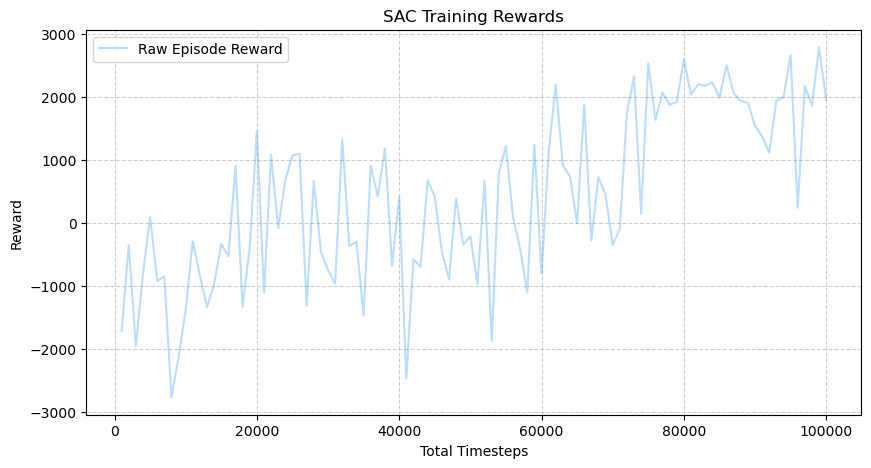

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3.common.results_plotter import load_results, ts2xy

def plot_learning_curve(log_folder, title="SAC Training Rewards"):
    # Load the results from the monitor file
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    
    plt.figure(figsize=(10, 5))
    
    # Plot raw rewards in light blue
    plt.plot(x, y, alpha=0.3, color='dodgerblue', label="Raw Episode Reward")
    
    # # Calculate and plot smoothed rewards
    # if len(y) > 50:
    #     # Convert to numpy array with .values to avoid the ValueError
    #     y_smoothed = pd.Series(y).rolling(window=50).mean().values
    #     plt.plot(x, y_smoothed, color='blue', linewidth=2, label="Rolling Mean (50 ep)")
    
    plt.xlabel('Total Timesteps')
    plt.ylabel('Reward')
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Run the plotting function
plot_learning_curve("./rec_ppo_asv_logs/")

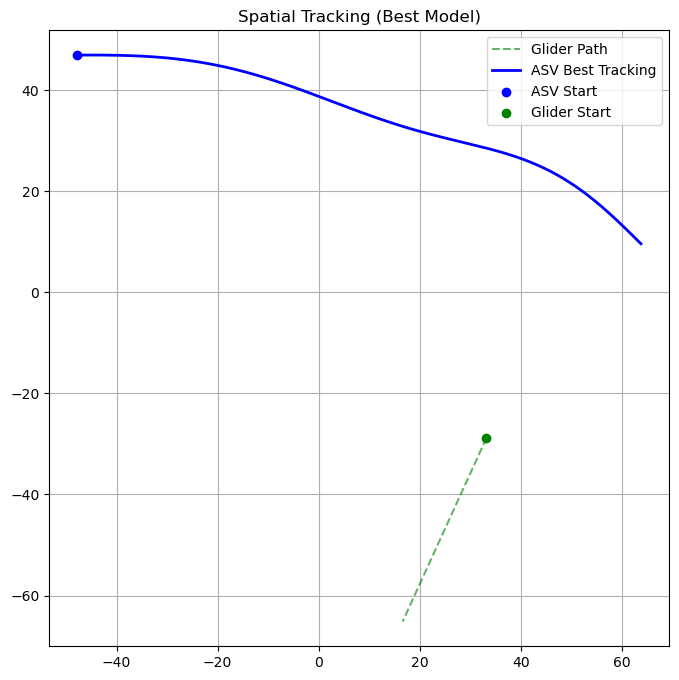

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
import os

# 1. Path to the best model
# Note: Adjust 'logs' to match the folder name you used in the EvalCallback
model_path = "./logs_rec_ppo/best_model/best_model.zip"

if not os.path.exists(model_path):
    print(f"Error: Could not find the best model at {model_path}")
else:
    # 2. Load the best model
    model = RecurrentPPO.load(model_path)
    env = AsvGliderBearingEnv()
    obs, _ = env.reset()

    asv_path, glider_path, rewards = [], [], []
    done = False

    # 3. Run a test episode
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        
        asv_path.append(env.asv_pos.copy())
        glider_path.append(env.glider_pos.copy())
        rewards.append(reward)
        done = terminated or truncated

    asv_path, glider_path = np.array(asv_path), np.array(glider_path)

    # 4. Plot the Map
    plt.figure(figsize=(8, 8))
    plt.plot(glider_path[:, 0], glider_path[:, 1], 'g--', label="Glider Path", alpha=0.6)
    plt.plot(asv_path[:, 0], asv_path[:, 1], 'b-', label="ASV Best Tracking", linewidth=2)
    plt.scatter(asv_path[0,0], asv_path[0,1], c='blue', label="ASV Start")
    plt.scatter(glider_path[0,0], glider_path[0,1], c='green', label="Glider Start")
    plt.title("Spatial Tracking (Best Model)")
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from sb3_contrib import RecurrentPPO  # From sb3_contrib, not stable_baselines3
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3.common.callbacks import BaseCallback, CallbackList, EvalCallback
# from asv_glider_bearing_dist_env import AsvGliderBearingEnv

# # --- 1. Define the Rollout Callback (Updated for LSTM) ---
# class TrajectoryPlotCallback(BaseCallback):
#     def __init__(self, eval_env, render_freq=10000, log_dir="./rollouts_rec_ppo/"):
#         super().__init__()
#         self.eval_env = eval_env
#         self.render_freq = render_freq
#         self.log_dir = log_dir
#         os.makedirs(self.log_dir, exist_ok=True)

#     def _on_step(self) -> bool:
#         if self.n_calls % self.render_freq == 0:
#             obs, _ = self.eval_env.reset()
#             asv_history, glider_history = [], []
#             done = False
            
#             # RecurrentPPO needs to track the LSTM state and episode start mask
#             lstm_states = None
#             episode_starts = np.ones((1,), dtype=bool) 
            
#             while not done:
#                 # IMPORTANT: We must pass state and episode_start for the LSTM
#                 action, lstm_states = self.model.predict(
#                     obs, 
#                     state=lstm_states, 
#                     episode_start=episode_starts, 
#                     deterministic=True
#                 )
                
#                 obs, reward, terminated, truncated, _ = self.eval_env.step(action)
                
#                 asv_history.append(self.eval_env.unwrapped.asv_pos.copy())
#                 glider_history.append(self.eval_env.unwrapped.glider_pos.copy())
                
#                 done = terminated or truncated
#                 # Update mask: if episode ended, next step is a 'start'
#                 episode_starts = np.array([done])

#             asv_history, glider_history = np.array(asv_history), np.array(glider_history)

#             plt.figure(figsize=(6, 6))
#             plt.plot(glider_history[:, 0], glider_history[:, 1], 'g--', label="Glider Path", alpha=0.6)
#             plt.plot(asv_history[:, 0], asv_history[:, 1], 'b-', label="ASV Path (LSTM)", linewidth=2)
#             plt.title(f"Recurrent PPO Rollout at Step {self.n_calls}")
#             plt.legend()
#             plt.grid(True)
            
#             save_path = os.path.join(self.log_dir, f"rollout_{self.n_calls}.png")
#             plt.savefig(save_path)
#             plt.close()
#             print(f">>> Saved Recurrent PPO trajectory to {save_path}")

#         return True

# # --- 2. Setup Directories and Environments ---
# log_dir = "./rec_ppo_asv_logs/"
# os.makedirs(log_dir, exist_ok=True)

# env = AsvGliderBearingEnv()
# env = Monitor(env, log_dir)
# eval_env = AsvGliderBearingEnv()

# # --- 3. Initialize Recurrent PPO Model ---
# model = RecurrentPPO(
#     "MlpLstmPolicy", # Policy with LSTM layers
#     env,
#     verbose=1,
#     learning_rate=2e-4, 
#     n_steps=2048,      # Rollout length
#     batch_size=64,     # Typical for Recurrent PPO
#     n_epochs=10,
#     gamma=0.99,
#     device="cuda",
# )

# # --- 4. Setup Evaluation ---
# eval_env = Monitor(eval_env, "./logs_rec_ppo/eval/")
# eval_callback = EvalCallback(
#     eval_env, 
#     best_model_save_path="./logs_rec_ppo/best_model",
#     log_path="./logs_rec_ppo/results", 
#     eval_freq=5000,
#     deterministic=True, 
#     render=False
# )

# plot_callback = TrajectoryPlotCallback(eval_env, render_freq=10000)
# callbacks = CallbackList([eval_callback, plot_callback])

# # --- 5. Train ---
# try:
#     print("Starting Recurrent PPO (LSTM) training...")
#     model.learn(
#         total_timesteps=100_000, 
#         callback=callbacks,
#         progress_bar=True
#     )
# except KeyboardInterrupt:
#     print("\nTraining interrupted.")
# finally:
#     env.close()
#     eval_env.close()
#     model.save("rec_ppo_asv_bearing_dist_final")
#     print("Environment closed and LSTM model saved.")

2026-01-12 23:02:26.869560: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-12 23:02:26.878547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768255346.889713  104174 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768255346.892844  104174 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768255346.900923  104174 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using cuda device
Wrapping the env in a DummyVecEnv.


Output()

Starting Recurrent PPO (LSTM) training...


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -1.03e+03 |
| time/              |           |
|    fps             | 967       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.21e+03   |
| time/                   |             |
|    fps                  | 564         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012565734 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -0.00142    |
|    learning_rate        | 0.0002      |
|    loss                 | 20.2        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0256     |
|    std                  | 0.989       |
|    value_loss           | 330         |
-----------------------------------------


Eval num_timesteps=5000, episode_reward=-1306.63 +/- 781.12

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | -1.31e+03  |
| time/                   |            |
|    total_timesteps      | 5000       |
| train/                  |            |
|    approx_kl            | 0.01292114 |
|    clip_fraction        | 0.157      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.82      |
|    explained_variance   | 0.0018     |
|    learning_rate        | 0.0002     |
|    loss                 | 66.2       |
|    n_updates            | 20         |
|    policy_gradient_loss | -0.0267    |
|    std                  | 0.989      |
|    value_loss           | 610        |
----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -943     |
| time/              |          |
|    fps             | 409      |
|    iterations      | 3        |
|    time_elapsed    | 15       |
|    total_timesteps | 6144     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.16e+03   |
| time/                   |             |
|    fps                  | 421         |
|    iterations           | 4           |
|    time_elapsed         | 19          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010698425 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.000816   |
|    learning_rate        | 0.0002      |
|    loss                 | 294         |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.016      |
|    std                  | 0.983       |
|    value_loss           | 199         |
-----------------------------------------


Eval num_timesteps=10000, episode_reward=-2132.57 +/- 1401.72

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -2.13e+03   |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.014529592 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.8        |
|    explained_variance   | -0.00117    |
|    learning_rate        | 0.0002      |
|    loss                 | 798         |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00763    |
|    std                  | 0.978       |
|    value_loss           | 1.05e+03    |
-----------------------------------------


>>> Saved Recurrent PPO trajectory to ./rollouts_rec_ppo/rollout_10000.png

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -1.28e+03 |
| time/              |           |
|    fps             | 368       |
|    iterations      | 5         |
|    time_elapsed    | 27        |
|    total_timesteps | 10240     |
----------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.16e+03   |
| time/                   |             |
|    fps                  | 379         |
|    iterations           | 6           |
|    time_elapsed         | 32          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.010280164 |
|    clip_fraction        | 0.0723      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.79       |
|    explained_variance   | 0.000777    |
|    learning_rate        | 0.0002      |
|    loss                 | 110         |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.015      |
|    std                  | 0.978       |
|    value_loss           | 788         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -1.16e+03   |
| time/                   |             |
|    fps                  | 388         |
|    iterations           | 7           |
|    time_elapsed         | 36          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.016473055 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.79       |
|    explained_variance   | -0.000376   |
|    learning_rate        | 0.0002      |
|    loss                 | 94.1        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0249     |
|    std                  | 0.98        |
|    value_loss           | 636         |
-----------------------------------------


Eval num_timesteps=15000, episode_reward=384.98 +/- 685.73

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | 385        |
| time/                   |            |
|    total_timesteps      | 15000      |
| train/                  |            |
|    approx_kl            | 0.01840489 |
|    clip_fraction        | 0.238      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.8       |
|    explained_variance   | 0.000804   |
|    learning_rate        | 0.0002     |
|    loss                 | 20.9       |
|    n_updates            | 70         |
|    policy_gradient_loss | -0.0336    |
|    std                  | 0.979      |
|    value_loss           | 228        |
----------------------------------------


New best mean reward!

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -1.07e+03 |
| time/              |           |
|    fps             | 366       |
|    iterations      | 8         |
|    time_elapsed    | 44        |
|    total_timesteps | 16384     |
----------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -972        |
| time/                   |             |
|    fps                  | 373         |
|    iterations           | 9           |
|    time_elapsed         | 49          |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.018397415 |
|    clip_fraction        | 0.27        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.78       |
|    explained_variance   | 0.000989    |
|    learning_rate        | 0.0002      |
|    loss                 | 19.7        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0374     |
|    std                  | 0.965       |
|    value_loss           | 99.6        |
-----------------------------------------


Eval num_timesteps=20000, episode_reward=-679.83 +/- 864.47

Episode length: 1000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | -680         |
| time/                   |              |
|    total_timesteps      | 20000        |
| train/                  |              |
|    approx_kl            | 0.0148948915 |
|    clip_fraction        | 0.201        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.76        |
|    explained_variance   | -0.00109     |
|    learning_rate        | 0.0002       |
|    loss                 | 164          |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.0245      |
|    std                  | 0.963        |
|    value_loss           | 415          |
------------------------------------------


>>> Saved Recurrent PPO trajectory to ./rollouts_rec_ppo/rollout_20000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -821     |
| time/              |          |
|    fps             | 353      |
|    iterations      | 10       |
|    time_elapsed    | 57       |
|    total_timesteps | 20480    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -748        |
| time/                   |             |
|    fps                  | 360         |
|    iterations           | 11          |
|    time_elapsed         | 62          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.010815387 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.76       |
|    explained_variance   | 1.45e-05    |
|    learning_rate        | 0.0002      |
|    loss                 | 252         |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0151     |
|    std                  | 0.962       |
|    value_loss           | 554         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -660         |
| time/                   |              |
|    fps                  | 366          |
|    iterations           | 12           |
|    time_elapsed         | 67           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0050399248 |
|    clip_fraction        | 0.0256       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.77        |
|    explained_variance   | 9.88e-05     |
|    learning_rate        | 0.0002       |
|    loss                 | 62.1         |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.0112      |
|    std                  | 0.964        |
|    value_loss           | 436          |
------------------------------------------


Eval num_timesteps=25000, episode_reward=-524.86 +/- 817.59

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -525        |
| time/                   |             |
|    total_timesteps      | 25000       |
| train/                  |             |
|    approx_kl            | 0.013224979 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.76       |
|    explained_variance   | 0.142       |
|    learning_rate        | 0.0002      |
|    loss                 | 35.2        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0216     |
|    std                  | 0.963       |
|    value_loss           | 184         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -526     |
| time/              |          |
|    fps             | 354      |
|    iterations      | 13       |
|    time_elapsed    | 74       |
|    total_timesteps | 26624    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -512        |
| time/                   |             |
|    fps                  | 360         |
|    iterations           | 14          |
|    time_elapsed         | 79          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.033187725 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.76       |
|    explained_variance   | -0.0987     |
|    learning_rate        | 0.0002      |
|    loss                 | 455         |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0108     |
|    std                  | 0.96        |
|    value_loss           | 616         |
-----------------------------------------


Eval num_timesteps=30000, episode_reward=-512.66 +/- 1255.22

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -513        |
| time/                   |             |
|    total_timesteps      | 30000       |
| train/                  |             |
|    approx_kl            | 0.014659558 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.75       |
|    explained_variance   | 0.353       |
|    learning_rate        | 0.0002      |
|    loss                 | 26          |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00454    |
|    std                  | 0.955       |
|    value_loss           | 460         |
-----------------------------------------


>>> Saved Recurrent PPO trajectory to ./rollouts_rec_ppo/rollout_30000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -518     |
| time/              |          |
|    fps             | 347      |
|    iterations      | 15       |
|    time_elapsed    | 88       |
|    total_timesteps | 30720    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -474        |
| time/                   |             |
|    fps                  | 352         |
|    iterations           | 16          |
|    time_elapsed         | 92          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.009535053 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.75       |
|    explained_variance   | 0.563       |
|    learning_rate        | 0.0002      |
|    loss                 | 222         |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00631    |
|    std                  | 0.961       |
|    value_loss           | 372         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -465       |
| time/                   |            |
|    fps                  | 356        |
|    iterations           | 17         |
|    time_elapsed         | 97         |
|    total_timesteps      | 34816      |
| train/                  |            |
|    approx_kl            | 0.02025139 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.75      |
|    explained_variance   | 0.572      |
|    learning_rate        | 0.0002     |
|    loss                 | 29.7       |
|    n_updates            | 160        |
|    policy_gradient_loss | 0.00135    |
|    std                  | 0.957      |
|    value_loss           | 348        |
----------------------------------------


Eval num_timesteps=35000, episode_reward=-467.14 +/- 1068.90

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -467        |
| time/                   |             |
|    total_timesteps      | 35000       |
| train/                  |             |
|    approx_kl            | 0.023299016 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.73       |
|    explained_variance   | 0.879       |
|    learning_rate        | 0.0002      |
|    loss                 | 193         |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0235     |
|    std                  | 0.942       |
|    value_loss           | 272         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -455     |
| time/              |          |
|    fps             | 349      |
|    iterations      | 18       |
|    time_elapsed    | 105      |
|    total_timesteps | 36864    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -389        |
| time/                   |             |
|    fps                  | 353         |
|    iterations           | 19          |
|    time_elapsed         | 110         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.009754049 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.71       |
|    explained_variance   | 0.000752    |
|    learning_rate        | 0.0002      |
|    loss                 | 151         |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0116     |
|    std                  | 0.936       |
|    value_loss           | 625         |
-----------------------------------------


Eval num_timesteps=40000, episode_reward=-268.74 +/- 1212.68

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -269        |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.010564624 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.7        |
|    explained_variance   | 0.57        |
|    learning_rate        | 0.0002      |
|    loss                 | 624         |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0222     |
|    std                  | 0.935       |
|    value_loss           | 747         |
-----------------------------------------


>>> Saved Recurrent PPO trajectory to ./rollouts_rec_ppo/rollout_40000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -377     |
| time/              |          |
|    fps             | 345      |
|    iterations      | 20       |
|    time_elapsed    | 118      |
|    total_timesteps | 40960    |
---------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -437       |
| time/                   |            |
|    fps                  | 348        |
|    iterations           | 21         |
|    time_elapsed         | 123        |
|    total_timesteps      | 43008      |
| train/                  |            |
|    approx_kl            | 0.02434513 |
|    clip_fraction        | 0.224      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.7       |
|    explained_variance   | 0.0665     |
|    learning_rate        | 0.0002     |
|    loss                 | 9.65       |
|    n_updates            | 200        |
|    policy_gradient_loss | -0.0284    |
|    std                  | 0.935      |
|    value_loss           | 1.03e+03   |
----------------------------------------


Eval num_timesteps=45000, episode_reward=7.57 +/- 605.73

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 7.57        |
| time/                   |             |
|    total_timesteps      | 45000       |
| train/                  |             |
|    approx_kl            | 0.019559488 |
|    clip_fraction        | 0.284       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.7        |
|    explained_variance   | 0.694       |
|    learning_rate        | 0.0002      |
|    loss                 | 435         |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0154     |
|    std                  | 0.933       |
|    value_loss           | 242         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -394     |
| time/              |          |
|    fps             | 342      |
|    iterations      | 22       |
|    time_elapsed    | 131      |
|    total_timesteps | 45056    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -405        |
| time/                   |             |
|    fps                  | 345         |
|    iterations           | 23          |
|    time_elapsed         | 136         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.009768903 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.7        |
|    explained_variance   | 0.347       |
|    learning_rate        | 0.0002      |
|    loss                 | 44.7        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0188     |
|    std                  | 0.931       |
|    value_loss           | 472         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -388        |
| time/                   |             |
|    fps                  | 348         |
|    iterations           | 24          |
|    time_elapsed         | 140         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.050666083 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.69       |
|    explained_variance   | 0.412       |
|    learning_rate        | 0.0002      |
|    loss                 | 29.4        |
|    n_updates            | 230         |
|    policy_gradient_loss | 0.00309     |
|    std                  | 0.925       |
|    value_loss           | 259         |
-----------------------------------------


Eval num_timesteps=50000, episode_reward=-1193.08 +/- 870.98

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | -1.19e+03  |
| time/                   |            |
|    total_timesteps      | 50000      |
| train/                  |            |
|    approx_kl            | 0.03033324 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.68      |
|    explained_variance   | 0.00912    |
|    learning_rate        | 0.0002     |
|    loss                 | 71.3       |
|    n_updates            | 240        |
|    policy_gradient_loss | -0.0236    |
|    std                  | 0.927      |
|    value_loss           | 516        |
----------------------------------------


>>> Saved Recurrent PPO trajectory to ./rollouts_rec_ppo/rollout_50000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -396     |
| time/              |          |
|    fps             | 342      |
|    iterations      | 25       |
|    time_elapsed    | 149      |
|    total_timesteps | 51200    |
---------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -404       |
| time/                   |            |
|    fps                  | 344        |
|    iterations           | 26         |
|    time_elapsed         | 154        |
|    total_timesteps      | 53248      |
| train/                  |            |
|    approx_kl            | 0.02141382 |
|    clip_fraction        | 0.224      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.68      |
|    explained_variance   | 0.42       |
|    learning_rate        | 0.0002     |
|    loss                 | 122        |
|    n_updates            | 250        |
|    policy_gradient_loss | -0.0239    |
|    std                  | 0.925      |
|    value_loss           | 237        |
----------------------------------------


Eval num_timesteps=55000, episode_reward=321.68 +/- 870.95

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 322         |
| time/                   |             |
|    total_timesteps      | 55000       |
| train/                  |             |
|    approx_kl            | 0.012297602 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.68       |
|    explained_variance   | 0.00108     |
|    learning_rate        | 0.0002      |
|    loss                 | 142         |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0161     |
|    std                  | 0.924       |
|    value_loss           | 923         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -353     |
| time/              |          |
|    fps             | 340      |
|    iterations      | 27       |
|    time_elapsed    | 162      |
|    total_timesteps | 55296    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -346        |
| time/                   |             |
|    fps                  | 343         |
|    iterations           | 28          |
|    time_elapsed         | 166         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.018082004 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.68       |
|    explained_variance   | 0.0934      |
|    learning_rate        | 0.0002      |
|    loss                 | 107         |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.0201     |
|    std                  | 0.922       |
|    value_loss           | 486         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -332        |
| time/                   |             |
|    fps                  | 345         |
|    iterations           | 29          |
|    time_elapsed         | 171         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.018526023 |
|    clip_fraction        | 0.322       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.67       |
|    explained_variance   | -0.0342     |
|    learning_rate        | 0.0002      |
|    loss                 | 239         |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00299    |
|    std                  | 0.918       |
|    value_loss           | 382         |
-----------------------------------------


Eval num_timesteps=60000, episode_reward=-171.25 +/- 1648.83

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -171        |
| time/                   |             |
|    total_timesteps      | 60000       |
| train/                  |             |
|    approx_kl            | 0.046170816 |
|    clip_fraction        | 0.303       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.66       |
|    explained_variance   | -0.501      |
|    learning_rate        | 0.0002      |
|    loss                 | 419         |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.0308     |
|    std                  | 0.914       |
|    value_loss           | 624         |
-----------------------------------------


>>> Saved Recurrent PPO trajectory to ./rollouts_rec_ppo/rollout_60000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -316     |
| time/              |          |
|    fps             | 340      |
|    iterations      | 30       |
|    time_elapsed    | 180      |
|    total_timesteps | 61440    |
---------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -257       |
| time/                   |            |
|    fps                  | 342        |
|    iterations           | 31         |
|    time_elapsed         | 185        |
|    total_timesteps      | 63488      |
| train/                  |            |
|    approx_kl            | 0.02558169 |
|    clip_fraction        | 0.291      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.66      |
|    explained_variance   | 0.242      |
|    learning_rate        | 0.0002     |
|    loss                 | 186        |
|    n_updates            | 300        |
|    policy_gradient_loss | -0.0252    |
|    std                  | 0.912      |
|    value_loss           | 550        |
----------------------------------------


Eval num_timesteps=65000, episode_reward=167.48 +/- 649.01

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | 167        |
| time/                   |            |
|    total_timesteps      | 65000      |
| train/                  |            |
|    approx_kl            | 0.22713776 |
|    clip_fraction        | 0.39       |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.65      |
|    explained_variance   | -0.00193   |
|    learning_rate        | 0.0002     |
|    loss                 | 410        |
|    n_updates            | 310        |
|    policy_gradient_loss | 0.0473     |
|    std                  | 0.914      |
|    value_loss           | 705        |
----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -237     |
| time/              |          |
|    fps             | 338      |
|    iterations      | 32       |
|    time_elapsed    | 193      |
|    total_timesteps | 65536    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -207        |
| time/                   |             |
|    fps                  | 340         |
|    iterations           | 33          |
|    time_elapsed         | 198         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.014454601 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.65       |
|    explained_variance   | -0.00129    |
|    learning_rate        | 0.0002      |
|    loss                 | 49.8        |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.00608    |
|    std                  | 0.91        |
|    value_loss           | 543         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -184        |
| time/                   |             |
|    fps                  | 342         |
|    iterations           | 34          |
|    time_elapsed         | 203         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.015427098 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.65       |
|    explained_variance   | -0.000941   |
|    learning_rate        | 0.0002      |
|    loss                 | 38.2        |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.0231     |
|    std                  | 0.908       |
|    value_loss           | 727         |
-----------------------------------------


Eval num_timesteps=70000, episode_reward=-443.28 +/- 1258.70

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | -443       |
| time/                   |            |
|    total_timesteps      | 70000      |
| train/                  |            |
|    approx_kl            | 0.02927846 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.64      |
|    explained_variance   | -6.32e-06  |
|    learning_rate        | 0.0002     |
|    loss                 | 88.3       |
|    n_updates            | 340        |
|    policy_gradient_loss | -0.0127    |
|    std                  | 0.906      |
|    value_loss           | 450        |
----------------------------------------


>>> Saved Recurrent PPO trajectory to ./rollouts_rec_ppo/rollout_70000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -185     |
| time/              |          |
|    fps             | 337      |
|    iterations      | 35       |
|    time_elapsed    | 212      |
|    total_timesteps | 71680    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -124        |
| time/                   |             |
|    fps                  | 339         |
|    iterations           | 36          |
|    time_elapsed         | 217         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.010990765 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.64       |
|    explained_variance   | -0.000358   |
|    learning_rate        | 0.0002      |
|    loss                 | 268         |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00648    |
|    std                  | 0.905       |
|    value_loss           | 418         |
-----------------------------------------


Eval num_timesteps=75000, episode_reward=225.11 +/- 788.64

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 225         |
| time/                   |             |
|    total_timesteps      | 75000       |
| train/                  |             |
|    approx_kl            | 0.019273987 |
|    clip_fraction        | 0.375       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.64       |
|    explained_variance   | 0.00103     |
|    learning_rate        | 0.0002      |
|    loss                 | 174         |
|    n_updates            | 360         |
|    policy_gradient_loss | 0.0283      |
|    std                  | 0.901       |
|    value_loss           | 750         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -85.1    |
| time/              |          |
|    fps             | 336      |
|    iterations      | 37       |
|    time_elapsed    | 225      |
|    total_timesteps | 75776    |
---------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -34.8      |
| time/                   |            |
|    fps                  | 338        |
|    iterations           | 38         |
|    time_elapsed         | 230        |
|    total_timesteps      | 77824      |
| train/                  |            |
|    approx_kl            | 0.02095379 |
|    clip_fraction        | 0.301      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.63      |
|    explained_variance   | -0.000332  |
|    learning_rate        | 0.0002     |
|    loss                 | 219        |
|    n_updates            | 370        |
|    policy_gradient_loss | 0.000255   |
|    std                  | 0.899      |
|    value_loss           | 992        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 14.1        |
| time/                   |             |
|    fps                  | 340         |
|    iterations           | 39          |
|    time_elapsed         | 234         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.010965863 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | -9.99e-05   |
|    learning_rate        | 0.0002      |
|    loss                 | 633         |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.0213     |
|    std                  | 0.898       |
|    value_loss           | 732         |
-----------------------------------------


Eval num_timesteps=80000, episode_reward=-591.94 +/- 1468.17

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | -592       |
| time/                   |            |
|    total_timesteps      | 80000      |
| train/                  |            |
|    approx_kl            | 0.02852475 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.62      |
|    explained_variance   | 0.000372   |
|    learning_rate        | 0.0002     |
|    loss                 | 418        |
|    n_updates            | 390        |
|    policy_gradient_loss | -0.00686   |
|    std                  | 0.896      |
|    value_loss           | 1.13e+03   |
----------------------------------------


>>> Saved Recurrent PPO trajectory to ./rollouts_rec_ppo/rollout_80000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 70.8     |
| time/              |          |
|    fps             | 336      |
|    iterations      | 40       |
|    time_elapsed    | 243      |
|    total_timesteps | 81920    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 122         |
| time/                   |             |
|    fps                  | 337         |
|    iterations           | 41          |
|    time_elapsed         | 248         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.010102003 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | -3.49e-05   |
|    learning_rate        | 0.0002      |
|    loss                 | 185         |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.015      |
|    std                  | 0.894       |
|    value_loss           | 803         |
-----------------------------------------


Eval num_timesteps=85000, episode_reward=2575.78 +/- 379.26

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 2.58e+03    |
| time/                   |             |
|    total_timesteps      | 85000       |
| train/                  |             |
|    approx_kl            | 0.012864127 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.61       |
|    explained_variance   | -0.000183   |
|    learning_rate        | 0.0002      |
|    loss                 | 267         |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00746    |
|    std                  | 0.894       |
|    value_loss           | 1.03e+03    |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 196      |
| time/              |          |
|    fps             | 335      |
|    iterations      | 42       |
|    time_elapsed    | 256      |
|    total_timesteps | 86016    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 236         |
| time/                   |             |
|    fps                  | 336         |
|    iterations           | 43          |
|    time_elapsed         | 261         |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.008296474 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.61       |
|    explained_variance   | 1.17e-05    |
|    learning_rate        | 0.0002      |
|    loss                 | 96.3        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.0115     |
|    std                  | 0.889       |
|    value_loss           | 969         |
-----------------------------------------


Eval num_timesteps=90000, episode_reward=1818.50 +/- 928.99

Episode length: 1000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1e+03      |
|    mean_reward          | 1.82e+03   |
| time/                   |            |
|    total_timesteps      | 90000      |
| train/                  |            |
|    approx_kl            | 0.03712851 |
|    clip_fraction        | 0.213      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.6       |
|    explained_variance   | -0.00017   |
|    learning_rate        | 0.0002     |
|    loss                 | 266        |
|    n_updates            | 430        |
|    policy_gradient_loss | 0.00478    |
|    std                  | 0.882      |
|    value_loss           | 604        |
----------------------------------------


>>> Saved Recurrent PPO trajectory to ./rollouts_rec_ppo/rollout_90000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 270      |
| time/              |          |
|    fps             | 333      |
|    iterations      | 44       |
|    time_elapsed    | 270      |
|    total_timesteps | 90112    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 291         |
| time/                   |             |
|    fps                  | 335         |
|    iterations           | 45          |
|    time_elapsed         | 275         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.015447178 |
|    clip_fraction        | 0.281       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.57       |
|    explained_variance   | -5.41e-05   |
|    learning_rate        | 0.0002      |
|    loss                 | 39          |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.00578    |
|    std                  | 0.872       |
|    value_loss           | 466         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1e+03     |
|    ep_rew_mean          | 326       |
| time/                   |           |
|    fps                  | 336       |
|    iterations           | 46        |
|    time_elapsed         | 279       |
|    total_timesteps      | 94208     |
| train/                  |           |
|    approx_kl            | 0.0287476 |
|    clip_fraction        | 0.339     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.55     |
|    explained_variance   | -6.35e-05 |
|    learning_rate        | 0.0002    |
|    loss                 | 285       |
|    n_updates            | 450       |
|    policy_gradient_loss | 0.00203   |
|    std                  | 0.866     |
|    value_loss           | 311       |
---------------------------------------


Eval num_timesteps=95000, episode_reward=2224.18 +/- 390.71

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 2.22e+03    |
| time/                   |             |
|    total_timesteps      | 95000       |
| train/                  |             |
|    approx_kl            | 0.010886237 |
|    clip_fraction        | 0.0601      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.55       |
|    explained_variance   | -0.000265   |
|    learning_rate        | 0.0002      |
|    loss                 | 184         |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00752    |
|    std                  | 0.863       |
|    value_loss           | 660         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 350      |
| time/              |          |
|    fps             | 334      |
|    iterations      | 47       |
|    time_elapsed    | 287      |
|    total_timesteps | 96256    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 384         |
| time/                   |             |
|    fps                  | 335         |
|    iterations           | 48          |
|    time_elapsed         | 292         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.023783397 |
|    clip_fraction        | 0.286       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.55       |
|    explained_variance   | 4.35e-05    |
|    learning_rate        | 0.0002      |
|    loss                 | 310         |
|    n_updates            | 470         |
|    policy_gradient_loss | -0.00184    |
|    std                  | 0.864       |
|    value_loss           | 568         |
-----------------------------------------


Eval num_timesteps=100000, episode_reward=2442.33 +/- 240.94

Episode length: 1000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 2.44e+03    |
| time/                   |             |
|    total_timesteps      | 100000      |
| train/                  |             |
|    approx_kl            | 0.012386222 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.54       |
|    explained_variance   | -9.76e-05   |
|    learning_rate        | 0.0002      |
|    loss                 | 200         |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0125     |
|    std                  | 0.863       |
|    value_loss           | 690         |
-----------------------------------------


>>> Saved Recurrent PPO trajectory to ./rollouts_rec_ppo/rollout_100000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 423      |
| time/              |          |
|    fps             | 332      |
|    iterations      | 49       |
|    time_elapsed    | 301      |
|    total_timesteps | 100352   |
---------------------------------


Environment closed and LSTM model saved.
